In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [2]:
# 데이터 불러오기

train = pd.read_csv("Dataset/Titanic/train.csv")
test= pd.read_csv("Dataset/Titanic/test.csv")
IDtest= test['PassengerId']

In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [4]:
# 이상치 탐색
# 데이터 프레임을 매개변수로 받아서 Tukey방식에 따른 이상치 관측의 인덱스 목록을 반환하는 함수 생성
def detect_outliers(df,n,features):
    outlier_indices=[]
    
    for col in features:
        # 1사분위
        Q1 = np.percentile(df[col],25)
        # 3사분위
        Q3 = np.percentile(df[col],75)
        # Interquartile range( IQR )
        IQR = Q3-Q1
        
        # 이상치 공식
        outlier_step = 1.5 * IQR
        
        # 각 특성의 이상치 인덱스 목록 결정
        outlier_list_col = df[(df[col]< Q1 - outlier_step) | (df[col]> Q3 + outlier_step)].index
        
        
        # 찾은 이상치 인덱스 추가
        outlier_indices.extend(outlier_list_col)

    # n개 이상의 이상치가 있는 것 찾기
    outlier_indices= Counter(outlier_indices)
    multiple_outliers= list(k for k, v in outlier_indices.items() if v >n)
        
    return multiple_outliers
    
# 나이, 형제배우자, 부모자식, Parch와 요금 피쳐들에 대한 이상치 확인
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [5]:
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [6]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [7]:
# 이상치 제거
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

In [8]:
# train과 test 데이터 조인 -> 데이터셋 규모 맞추기
train_len = len(train)
dataset= pd.concat(objs=[train,test],axis=0).reset_index(drop=True)

In [9]:
# 널 데이터 NaN으로 채우기
dataset = dataset.fillna(np.nan)

# 확인

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


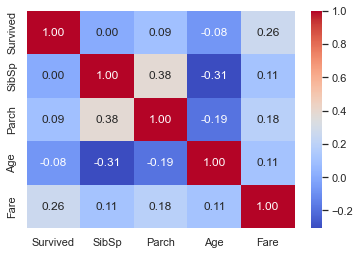

In [13]:
g= sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True, fmt=".2f",cmap='coolwarm')

C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


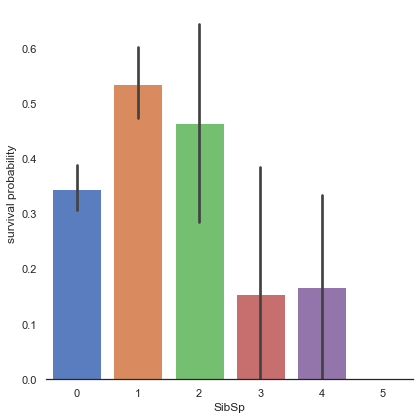

In [14]:
# SibSp 피쳐 확인하기
g = sns.factorplot(x='SibSp',y="Survived",data=train, kind='bar', size=6, palette='muted')
g.despine(left=True) # 테두리 제거
g = g.set_ylabels("survival probability")

C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


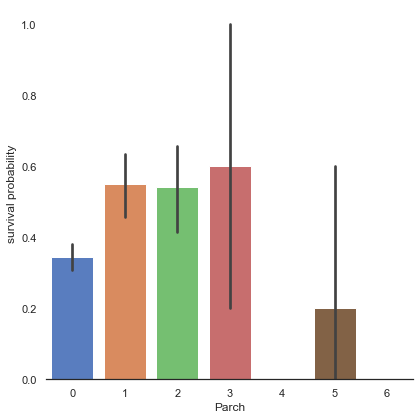

In [15]:
# Parch 피쳐 확인하기

g = sns.factorplot(x='Parch', y='Survived',data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


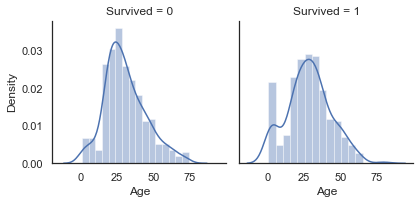

In [16]:
# Age 피쳐 확인하기
g = sns.FacetGrid(train,col='Survived')
g = g.map(sns.distplot,'Age')

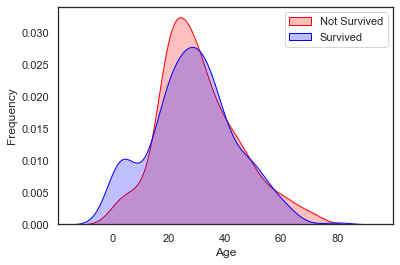

In [17]:
# Age 분포 확인하기
g = sns.kdeplot(train['Age'][(train['Survived']==0)&(train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1)&(train['Age'].notnull())], ax=g, color="Blue",shade=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(['Not Survived','Survived'])

In [18]:
# Fare 결측치 확인
dataset['Fare'].isnull().sum()

1

C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


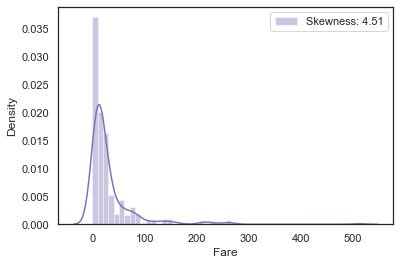

In [19]:
# Fare 분포 확인
g = sns.distplot(dataset['Fare'], color='m', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g= g.legend(loc='best')

In [20]:
# 편차가 너무 크기 때문에 로그를 취함
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


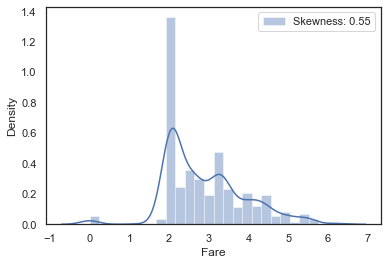

In [21]:
g= sns.distplot(dataset['Fare'], color='b', label='Skewness: %.2f'%(dataset['Fare'].skew()))
g= g.legend(loc='best')

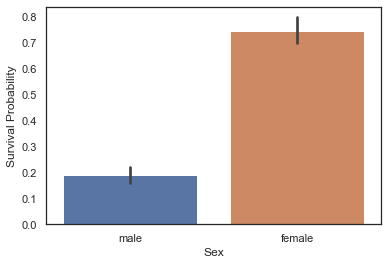

In [22]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [23]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


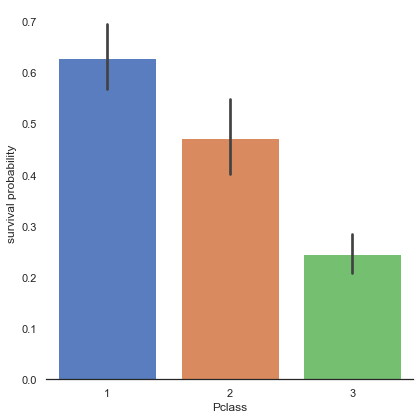

In [24]:
# Pclass 탐색하기
g = sns.factorplot(x="Pclass", y='Survived', data=train, kind='bar',size=6, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


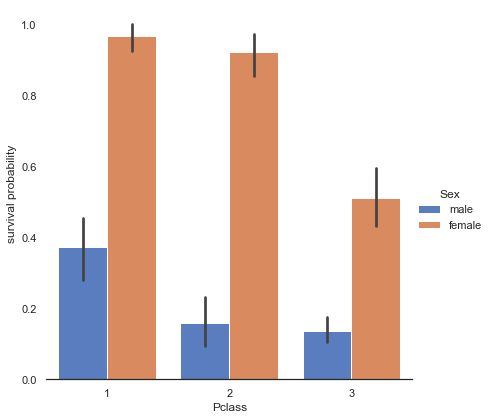

In [25]:
# Pclass를 성별로 분류하여 생존살펴보기
g= sns.factorplot(x='Pclass',y='Survived', hue='Sex', data=train, size=6,kind='bar',palette='muted')
g.despine(left=True)
g=g.set_ylabels("survival probability")

In [26]:
# Embarked 살펴보기
dataset['Embarked'].isnull().sum()

2

In [27]:
# Embarked 결측치 최빈값으로 채우기
dataset['Embarked'] = dataset['Embarked'].fillna('S')


C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


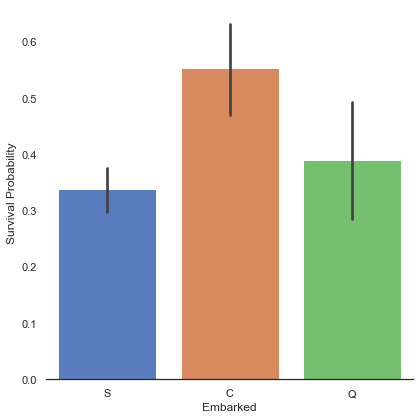

In [28]:
# Embarked 생존과 비교
g = sns.factorplot(x='Embarked', y= 'Survived', data=train, size=6,kind='bar' ,palette="muted")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")


C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


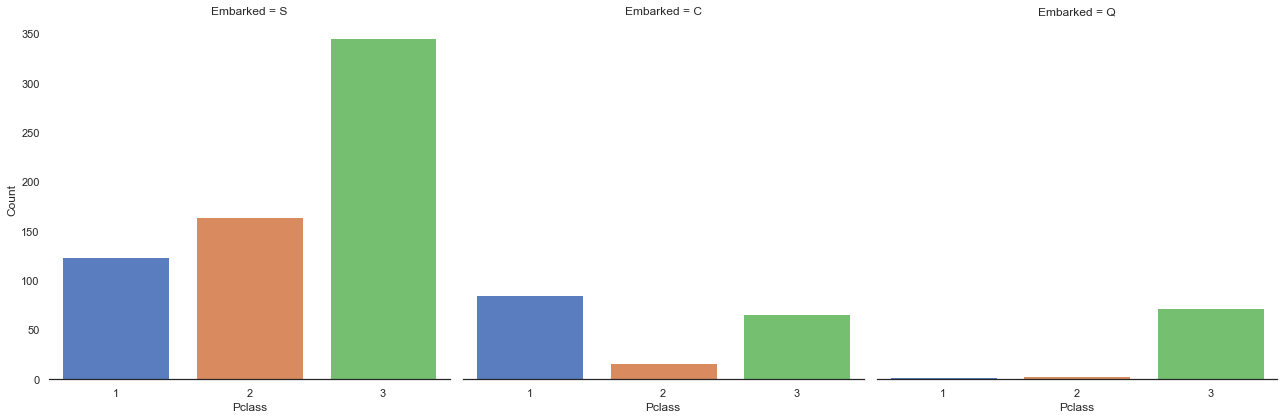

In [29]:
# Pclass와 Embarked 비교
g= sns.factorplot('Pclass', col='Embarked', data=train,size=6, kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels("Count")

C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) h

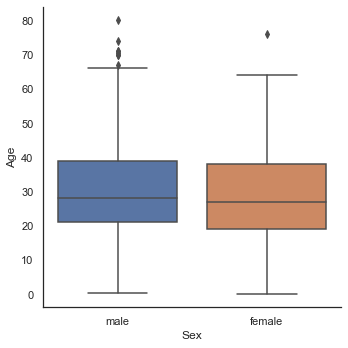

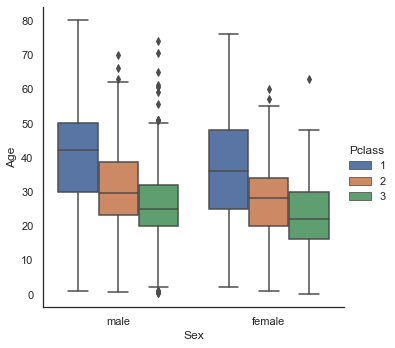

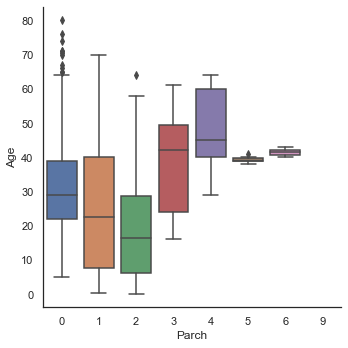

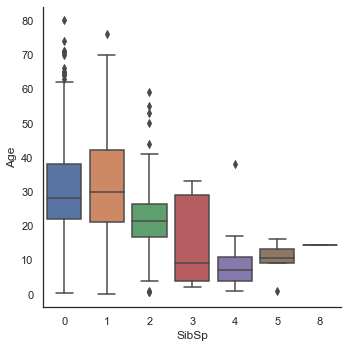

In [30]:
# 결측치 처리하기
g= sns.factorplot( y='Age', x='Sex', data=dataset,kind='box')
g= sns.factorplot(y='Age',x='Sex', hue="Pclass", data=dataset, kind='box')
g= sns.factorplot(y='Age', x='Parch', data=dataset,kind='box')
g= sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

In [31]:
# 성별을 수치화
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

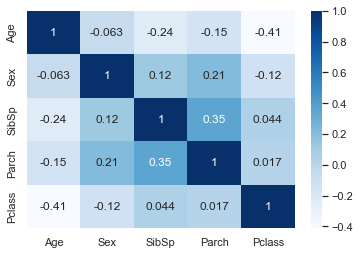

In [33]:
# 주요한 피쳐들 상관관계 분석
g= sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(), cmap='Blues', annot=True)

In [45]:
# Age 결측치 채우기

index_NaN_age= list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med= dataset['Age'].median()
    
    #결측치가 있는 인덱스의 조건과 같은 행의 Age들 중 중간값
    age_pred= dataset['Age'][((dataset['SibSp']== dataset.iloc[i]['SibSp'])&(dataset['Parch']==dataset.iloc[i]['Parch'])&(dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred): #값이 nan이 아닌 경우
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_

C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_

C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_

C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_

C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_

C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_

C:\Users\easyd\miniforge3\envs\easydong2\lib\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_med
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\easyd\AppData\Local\Temp\ipykernel_14332\2752430589.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

False